# Week 15: Poly-Square Mapping

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import time

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from scipy.spatial import Delaunay
from scipy.optimize import minimize

from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_adjacent_vertices_with_boundary_vertex, retrieve_adjacent_vertices_with_vertex, retrieve_boundary_edges_related_vertices_2D
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_boundary_vertices
from util.mesh.triangle.algorithm.R2.mapping_poly_square import Liu_2017

from util.pyvista_util import preprocess, postprocess

In [ ]:
class boundary_smoothing_tutte:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
            return 1 / np.sin(2*angle)
        else:
            return np.power(np.sin(2*angle), 2)
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E_angle = 0
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            E_angle += activation(angle)
#             if cos_theta > 0:
#                 E_angle +=  1 / (2*sin_theta)
#             else:
#                 E_angle += np.power(np.sin(2*angle), 2)

        return E_angle
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(self.vertices, self.faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [117]:
class poly_square_tutte:
    def __init__(self, vertices, faces, lambda_=0.1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        self.loss_history = []
        
        # Hyper parameters
        self.lambda_=lambda_
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
#             return np.power(np.cos(angle), 2) / angle
            return 1/np.sin(angle) - 1
        else:
            return 0
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            sin_theta = np.linalg.norm(np.cross(edge1, edge2)) / (L1 * L2)
            if cos_theta > 0:
                E_angle +=  (1 / sin_theta - 1)
#                 angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
#                 E_angle += lambda_[i] * cos_theta / ( angle)
            
            E_align += L1*(np.sum(np.absolute(edge1/L1)) - 1) + L2*(np.sum(np.absolute(edge2/L2)) - 1)

        return E_align + self.lambda_*E_angle
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(self.vertices, self.faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS", callback=self.callback)
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS", callback=self.callback)
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def callback(self, x0):
        self.loss_history.append(self.objective(x0))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()
        
    def v_loss(self, save_dict=''):
        iterations = list(range(1, len(self.loss_history) + 1))
        plt.plot(iterations, self.loss_history, '-o', label='Loss Value', markersize=3)
        plt.title('Loss vs. Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.legend()
        plt.show()

In [48]:
postprocess("./mesh/tritess/tritess_output_polysquare_100_10.ply", tritess_test.solution, tritess_test.faces)

# =============================================================

In [143]:
cat_v, cat_f = preprocess("./mesh/cat/cat_input.ply")
cat_test = poly_square_tutte(cat_v, cat_f, lambda_=5)

In [123]:
cat_test.optimize_default()

In [124]:
cat_test.mapping()

In [125]:
cat_test.res

      fun: 53.81256771216642
 hess_inv: array([[ 0.21204721,  0.00766952,  0.2050343 , ..., -0.04490616,
         0.04271826, -0.04602669],
       [ 0.00766952,  0.31148698, -0.00545726, ...,  0.00498053,
         0.04400548,  0.01299528],
       [ 0.2050343 , -0.00545726,  0.21441607, ..., -0.03735961,
         0.03288679, -0.04273452],
       ...,
       [-0.04490616,  0.00498053, -0.03735961, ...,  0.30625537,
        -0.08886001,  0.32023638],
       [ 0.04271826,  0.04400548,  0.03288679, ..., -0.08886001,
         0.54968643, -0.13898157],
       [-0.04602669,  0.01299528, -0.04273452, ...,  0.32023638,
        -0.13898157,  0.38221253]])
      jac: array([-2.06155396e+00,  1.48390198e+00,  5.79090118e-02,  3.18094254e-01,
        2.99453735e-03, -3.63686466e+00,  3.42750549e-03,  3.71825695e+00,
       -1.80622673e+00, -1.89248180e+00,  1.80958462e+00,  1.99587822e+00,
       -1.02996826e-04, -1.10397339e-02,  8.86917114e-05, -3.96055317e+00,
       -2.64930725e-03,  3.88077736e

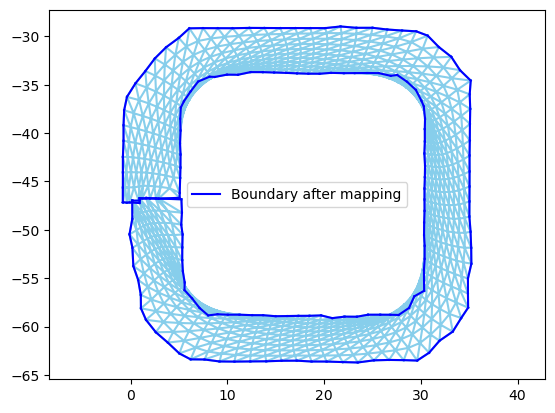

In [127]:
cat_test.v_plt(show_origin=False, 
               show_BV=False, 
               show_vertices=False, 
               show_inner_edges=True, 
#                save_dict='./mesh/cat/boundary_compare_100_10.png'
              )

In [153]:
ring_v, ring_f = preprocess("./mesh/cat/cat_output_smoothing_2.ply")
ring_test = poly_square_tutte(ring_v, ring_f, lambda_=10)

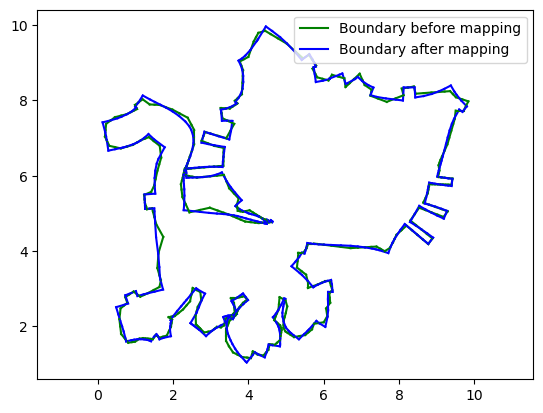

In [154]:
# plt.triplot(poly.solution[:,0], poly.solution[:,1], faces)
for edge in cat_test.BE_r_V:
    plt.plot(cat_test.vertices[np.array(edge), 0], cat_test.vertices[np.array(edge), 1], 'g-')
    plt.plot(ring_test.solution[np.array(edge), 0], ring_test.solution[np.array(edge), 1], 'b-')
plt.plot(cat_test.vertices[np.array(ring_test.BE_r_V[0]), 0], cat_test.vertices[np.array(ring_test.BE_r_V[0]), 1], label='Boundary before mapping', color='green')
plt.plot(ring_test.solution[np.array(ring_test.BE_r_V[0]), 0], ring_test.solution[np.array(ring_test.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')


# plt.plot(ring_test.vertices[:,0], ring_test.vertices[:,1], 'o', color="green")
# plt.plot(ring_test.solution[:,0], ring_test.solution[:,1], 'o', color="blue")
# plt.plot(poly.solution[[4,5,0], 0], poly.solution[[4,5,0], 1], 'o', color='red')
# plt.plot(poly.vertices[[4,5,0], 0], poly.vertices[[4,5,0], 1], 'o', color='red')

# plt.triplot(ring_test.vertices[:,0], ring_test.vertices[:,1], ring_test.faces, color='greenyellow')
# plt.triplot(ring_test.solution[:,0], ring_test.solution[:,1], ring_test.faces, color='lightskyblue')

plt.axis('equal')
plt.legend()
# plt.xlim(3,8)
# plt.ylim(-38,-33)
# plt.savefig('./mesh/1problems/foldover/example_ring_before', dpi=300)
plt.show()

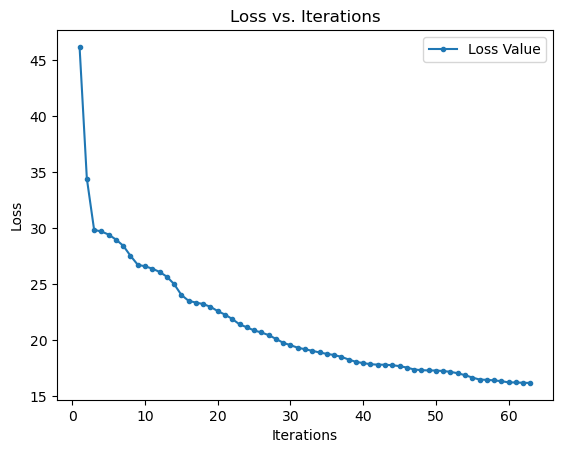

In [57]:
iterations = list(range(1, len(cat_test.loss_history) + 1))
plt.plot(iterations, cat_test.loss_history, '-o', label='Loss Value', markersize=3)
plt.title('Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('./mesh/cat/cat_loss.png', dpi=300)
plt.legend()
plt.show()

In [55]:
postprocess("./mesh/cat/cat_output_poly_100_10.ply", cat_test.solution, cat_test.faces)

# ============================================================

In [35]:
cat_test.optimize_default()

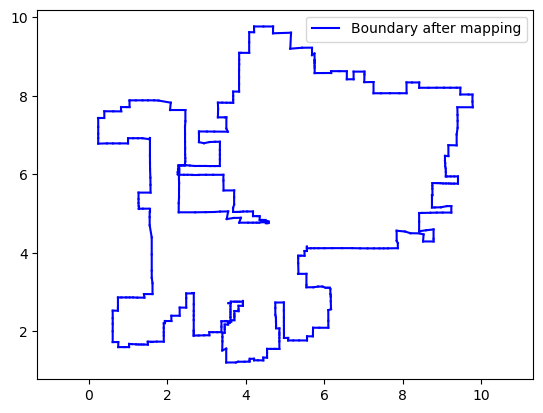

In [39]:
cat_test.v_plt(show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False)

In [40]:
postprocess("./mesh/cat/cat_output_perfect2.ply", cat_test.solution, cat_test.faces)

In [45]:
cat_test.optimize_default()

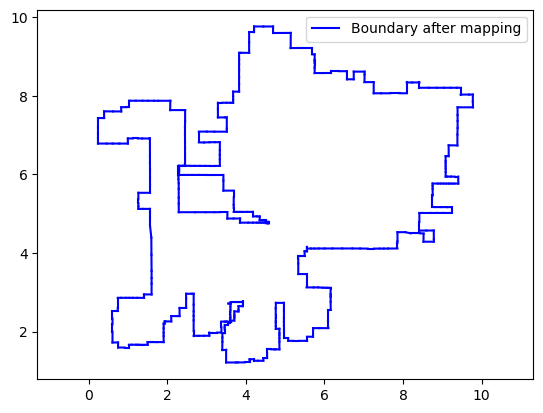

In [47]:
cat_test.v_plt(show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False)

In [48]:
postprocess("./mesh/cat/cat_output_PolySquare.ply", cat_test.solution, cat_test.faces)

# ==============================================================

In [233]:
horse_v, horse_f = preprocess("./mesh/bunny/bunny_input.ply")
horse_test = poly_square_tutte(horse_v, horse_f, lambda_=10)

In [234]:
start_time = time.time()
horse_test.lambda_=0.1
max_iter = 20
horse_test.optimize_default()
print("done!")
horse_test.lambda_=1
horse_test.optimize_default()
print("done!")
horse_test.lambda_=3
horse_test.optimize_default()
print("done!")
horse_test.lambda_=5
horse_test.optimize_default()
horse_test.lambda_=10
horse_test.optimize_default()
end_time = time.time()
print(end_time - start_time)

done!
done!
done!
1927.4248111248016


In [235]:
start_time = time.time()
horse_test.mapping()
end_time = time.time()
print(end_time - start_time)

0.10746979713439941


In [236]:
print(horse_test.res.nit, horse_test.res.njev, horse_test.res.nfev, horse_test.res.fun)

1 74 20658 0.4500444982632821


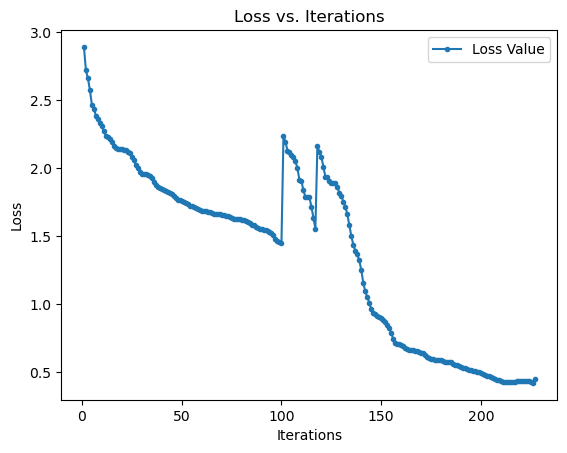

In [237]:
iterations = list(range(1, len(horse_test.loss_history) + 1))

plt.plot(iterations, horse_test.loss_history, '-o', label='Loss Value', markersize=3)
plt.title('Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('./mesh/bunny/polysquare/loss_100_dynamic_up.png', dpi=300)
plt.legend()
plt.show()

In [238]:
postprocess("./mesh/bunny/polysquare/100_dynamic_up.ply", horse_test.solution, horse_test.faces)

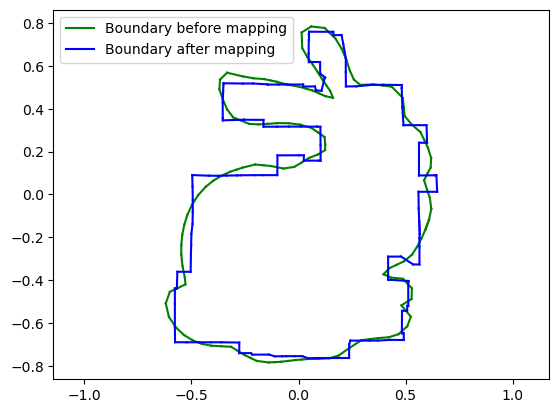

In [239]:
horse_test.v_plt(show_origin=True, 
               show_BV=False, 
               show_vertices=False, 
               show_inner_edges=False, 
               save_dict='./mesh/bunny/polysquare/compare_100_dynamic_up.png'
              )

# ===========================================================

In [110]:
rabbit_v, rabbit_f = preprocess("./mesh/bunny/bunny_input.ply")
rabbit_test = poly_square_tutte(rabbit_v, rabbit_f, lambda_=10)

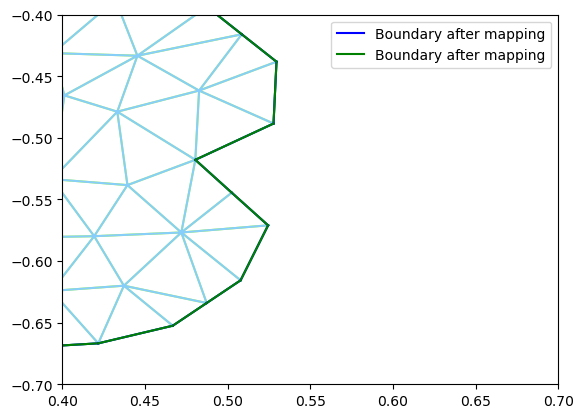

In [111]:
# plt.triplot(poly.solution[:,0], poly.solution[:,1], faces)
for edge in rabbit_test.BE_r_V:
    plt.plot(rabbit_test.solution[np.array(edge), 0], rabbit_test.solution[np.array(edge), 1], 'b-')
    plt.plot(rabbit_test.vertices[np.array(edge), 0], rabbit_test.vertices[np.array(edge), 1], 'g-')
plt.plot(rabbit_test.solution[np.array(rabbit_test.BE_r_V[0]), 0], rabbit_test.solution[np.array(rabbit_test.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
plt.plot(rabbit_test.vertices[np.array(rabbit_test.BE_r_V[0]), 0], rabbit_test.vertices[np.array(rabbit_test.BE_r_V[0]), 1], label='Boundary after mapping', color='green')

plt.triplot(rabbit_test.vertices[:,0], rabbit_test.vertices[:,1], rabbit_test.faces, color='greenyellow')
plt.triplot(rabbit_test.solution[:,0], rabbit_test.solution[:,1], rabbit_test.faces, color='lightskyblue')

plt.xlim(0.4,0.7)
plt.ylim(-0.7,-0.4)
# plt.axis('equal')
plt.legend()
plt.savefig('./mesh/1problems/foldover/bunny_origin.png', dpi=300)
plt.show()

In [81]:
rabbit_test.optimize(30)

Round  0  done!
Round  1  done!
Round  2  done!
Round  3  done!
Round  4  done!
Round  5  done!
Round  6  done!
Round  7  done!
Round  8  done!
Round  9  done!
Round  10  done!
Round  11  done!
Round  12  done!
Round  13  done!
Round  14  done!
Round  15  done!
Round  16  done!
Round  17  done!
Round  18  done!
Round  19  done!
Round  20  done!
Round  21  done!
Round  22  done!
Round  23  done!
Round  24  done!
Round  25  done!
Round  26  done!
Round  27  done!
Round  28  done!
Round  29  done!


In [92]:
start_time = time.time()
rabbit_test.optimize_default()
end_time = time.time()
print(end_time - start_time)

4928.93133354187


In [83]:
start_time = time.time()
rabbit_test.mapping()
end_time = time.time()
print(end_time - start_time)

0.5192852020263672


In [89]:
rabbit_test.res

      fun: 35.14188557910202
 hess_inv: array([[ 1.00025318e+00,  3.69093916e-04, -4.23418120e-04, ...,
        -2.82907506e-05, -2.04913975e-05, -3.77759782e-05],
       [ 3.69093916e-04,  1.00053807e+00, -6.17263284e-04, ...,
        -4.12425039e-05, -2.98725933e-05, -5.50702540e-05],
       [-4.23418120e-04, -6.17263284e-04,  1.00070811e+00, ...,
         4.73125457e-05,  3.42693737e-05,  6.31757416e-05],
       ...,
       [-2.82907506e-05, -4.12425039e-05,  4.73125457e-05, ...,
         1.00000316e+00,  2.28975077e-06,  4.22116847e-06],
       [-2.04913975e-05, -2.98725933e-05,  3.42693737e-05, ...,
         2.28975077e-06,  1.00000166e+00,  3.05736256e-06],
       [-3.77759782e-05, -5.50702540e-05,  6.31757416e-05, ...,
         4.22116847e-06,  3.05736256e-06,  1.00000564e+00]])
      jac: array([-2.60858583, -3.80190325,  4.35889196, ...,  0.28947783,
        0.21191788,  0.39073181])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 8071
      nit: 1
    

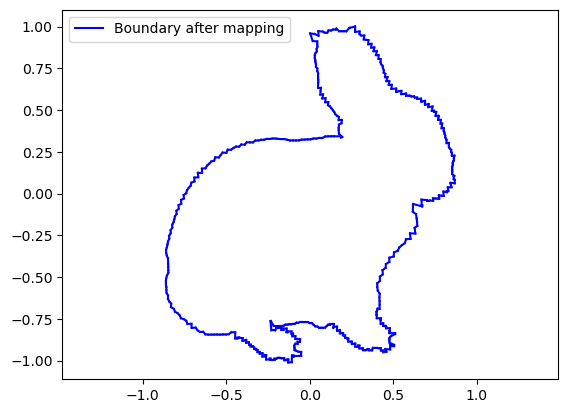

In [93]:
rabbit_test.v_plt(show_origin=False, 
               show_BV=False, 
               show_vertices=False, 
               show_inner_edges=False, 
#                save_dict='./mesh/horse/boundary_compare_100_10.png'
              )

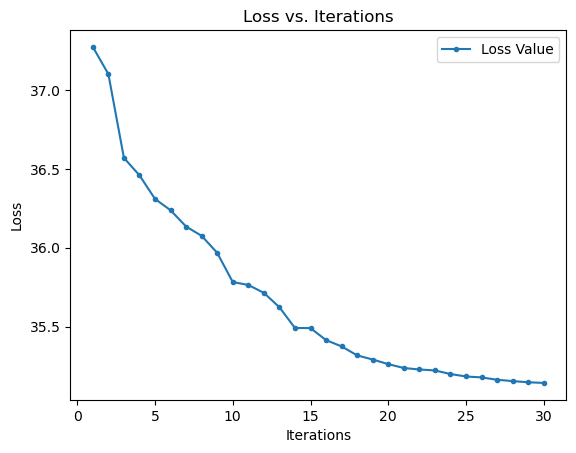

In [91]:
iterations = list(range(1, len(rabbit_test.loss_history) + 1))

plt.plot(iterations, rabbit_test.loss_history, '-o', label='Loss Value', markersize=3)
plt.title('Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('./mesh/horse/horse_loss.png', dpi=300)
plt.legend()
plt.show()